# mTSP Environment

Differences with CVRP:

- We have a fixed maximum number of vehicles
- No capacity constraint
- Objective: minimize maximum subtour length (minmax)

In [1]:
import sys; sys.path.append(2*"../")

from typing import Optional

import numpy as np
import torch
from tensordict.tensordict import TensorDict

from torchrl.data import (
    BoundedTensorSpec,
    CompositeSpec,
    UnboundedContinuousTensorSpec,
    UnboundedDiscreteTensorSpec,
)

from rl4co.envs.utils import batch_to_scalar
from rl4co.envs.base import RL4COEnvBase


/home/botu/Dev/rl4co/env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def _reset(self, td: Optional[TensorDict] = None, batch_size=None) -> TensorDict:
    # Initialize data
    if batch_size is None:
        batch_size = self.batch_size if td is None else td["locs"].shape[:-2]

    device = td.device if td is not None else self.device
    if td is None or td.is_empty():
        td = self.generate_data(batch_size=batch_size)

    # Keep track of the agent number to know when to stop
    agent_idx = torch.zeros((*batch_size,), dtype=torch.int64, device=device)
    
    # Make variable for max_subtour_length between subtours
    max_subtour_length = torch.zeros(batch_size, dtype=torch.float32, device=device)
    current_length = torch.zeros(batch_size, dtype=torch.float32, device=device)

    # Other variables
    current_node = torch.zeros((*batch_size,), dtype=torch.int64, device=device)
    available = torch.ones(
        (*batch_size, self.num_loc), dtype=torch.bool, device=device
    )  # 1 means not visited, i.e. action is allowed
    available[..., 0] = 0  # Depot is not available as first node
    i = torch.zeros((*batch_size,), dtype=torch.int64, device=device)
    
    return TensorDict(
        {
            "locs": td['locs'], # depot is first node
            "num_agents": td['num_agents'],
            "max_subtour_length": max_subtour_length,
            "current_length": current_length,
            "agent_idx": agent_idx,
            "first_node": current_node,
            "current_node": current_node,
            "i": i,
            "action_mask": available,
        },
        batch_size=batch_size,
    )

In [3]:
def _make_spec(self, td_params: TensorDict):
    """Make the observation and action specs from the parameters."""
    self.observation_spec = CompositeSpec(
        locs=BoundedTensorSpec(
            minimum=self.min_loc,
            maximum=self.max_loc,
            shape=(self.num_loc, 2),
            dtype=torch.float32,
        ),
        num_agents=UnboundedDiscreteTensorSpec(
            shape=(1),
            dtype=torch.int64,
        ),
        agent_idx=UnboundedDiscreteTensorSpec(
            shape=(1),
            dtype=torch.int64,
        ),
        current_length=UnboundedContinuousTensorSpec(
            shape=(1),
            dtype=torch.float32,
        ),
        max_subtour_length=UnboundedContinuousTensorSpec(
            shape=(1),
            dtype=torch.float32,
        ),
        first_node=UnboundedDiscreteTensorSpec(
            shape=(1),
            dtype=torch.int64,
        ),
        current_node=UnboundedDiscreteTensorSpec(
            shape=(1),
            dtype=torch.int64,
        ),
        i=UnboundedDiscreteTensorSpec(
            shape=(1),
            dtype=torch.int64,
        ),
        action_mask=UnboundedDiscreteTensorSpec(
            shape=(self.num_loc),
            dtype=torch.bool,
        ),
        shape=(),
    )
    self.input_spec = self.observation_spec.clone()
    self.action_spec = BoundedTensorSpec(
        shape=(1,),
        dtype=torch.int64,
        minimum=0,
        maximum=self.num_loc,
    )
    self.reward_spec = UnboundedContinuousTensorSpec()
    self.done_spec = UnboundedDiscreteTensorSpec(dtype=torch.bool)

In [4]:
def generate_data(self, batch_size) -> TensorDict:

    # Batch size input check
    batch_size = [batch_size] if isinstance(batch_size, int) else batch_size

    # Initialize the locations (including the depot which is always the first node)
    locs = (
        torch.FloatTensor(*batch_size, self.num_loc, 2)
        .uniform_(self.min_loc, self.max_loc)
        .to(self.device)
    )
    
    # Initialize the num_agents: either fixed or random integer between min and max
    if self.min_num_agents == self.max_num_agents:
        num_agents = torch.ones(batch_size, dtype=torch.int64, device=self.device) * self.min_num_agents
    else:
        torch.randint(
        self.min_num_agents, self.max_num_agents, size=batch_size, device=self.device
    )

    return TensorDict(
        {
            "locs": locs,
            "num_agents": num_agents,
        },
        batch_size=batch_size,
    )

In [5]:
def get_reward(self, td, actions) -> TensorDict:

    if self.cost_type == "minmax":
        # With minmax, get the maximum distance among subtours, calculated in the model
        return td["reward"]
    
    elif self.cost_type == "distance":
        locs = td["locs"]
        # Gather locations in order of tour
        locs = locs.gather(1, actions.unsqueeze(-1).expand_as(locs))

        # Concatenate as last node the depot
        locs = torch.cat([locs, locs[..., 0:1]], dim=-2)
        locs_next = torch.roll(locs, 1, dims=1)
        return  -((locs_next - locs).norm(p=2, dim=2).sum(1))
    else:
        raise ValueError(f"Cost type {self.cost_type} not supported")

In [6]:
def gather_by_index(source, index):
    target = torch.gather(
        source, 1, index.unsqueeze(-1).expand(-1, -1, source.size(-1))
    )
    return target


def distance(x, y):
    """Euclidean distance between two tensors of shape (..., n, dim)"""
    return torch.norm(x - y, p=2, dim=-1)


In [7]:
def _step(td: TensorDict) -> TensorDict:
    
    is_first_action = batch_to_scalar(td["i"]) == 0
    current_node = td["action"]
    first_node = current_node if is_first_action else td["first_node"]

    # Get the locations of the current node and the previous node and the depot
    cur_loc = gather_by_index(td['locs'], current_node[..., None]).squeeze(-2)
    prev_loc = gather_by_index(td['locs'], td['current_node'][..., None]).squeeze(-2)
    depot_loc = td["locs"][..., 0, :]

    # If current_node is the depot, then increment agent_idx
    cur_agent_idx = td["agent_idx"] + (current_node == 0).long()

    # Set not visited to 0 (i.e., we visited the node)
    available = td["action_mask"].scatter(
        -1, current_node[..., None].expand_as(td["action_mask"]), 0
    )
    # Available[..., 0] is the depot, which is always available unless:
    # - current_node is the depot
    # - agent_idx greater than num_agents -1
    available[..., 0] = torch.logical_and(current_node != 0, td['agent_idx'] < td['num_agents'] - 1)

    # We are done there are no unvisited locations except the depot
    done = torch.count_nonzero(available[..., 1:], dim=-1) == 0

    # If done is True, then we make the depot available again, so that it will be selected as the next node with prob 1
    # available[..., 0] = done # where done = 1, available = 1
    available[..., 0] = torch.logical_or(done, available[..., 0])

    # If current agent is different from previous agent, then we have a new subtour and reset the length, otherwise we add the new distance
    current_length = torch.where(cur_agent_idx != td["agent_idx"], 
                                 torch.zeros_like(td["current_length"]), 
                                 td["current_length"] + distance(cur_loc, prev_loc)
                            )
    
    # If done, we add the distance from the current_node to the depot as well
    current_length = torch.where(done, current_length + distance(cur_loc, depot_loc), current_length)
                                                                              
    # print("current_length", current_length.shape)
    # print("max_subtour_length", td["max_subtour_length"].shape)
    # print("distance", distance(cur_loc, prev_loc).shape)
    # print("done", done.shape)
    # print("cur_loc", cur_loc.shape)
    # print("prev_loc", prev_loc.shape)

    # We update the max_subtour_length and reset the current_length
    max_subtour_length = torch.where(current_length > td["max_subtour_length"], current_length, td["max_subtour_length"])

    # The reward is the negative of the max_subtour_length (minmax objective)
    reward = - max_subtour_length.squeeze(-1)

    # The output must be written in a ``"next"`` entry
    return TensorDict(
        {
            "next": {
                "locs": td["locs"],
                "num_agents": td['num_agents'],
                "max_subtour_length": max_subtour_length,
                "current_length": current_length,
                "agent_idx": cur_agent_idx,
                "first_node": first_node,
                "current_node": current_node,
                "i": td["i"] + 1,
                "action_mask": available,
                "reward": reward,
                "done": done,
            }
        },
        td.shape,
    )

In [8]:
class MTSPEnv(RL4COEnvBase):
    name = "mtsp"

    def __init__(
        self,
        num_loc: int = 10,
        min_loc: float = 0,
        max_loc: float = 1,
        min_num_agents: int = 1,
        max_num_agents: int = 10,
        cost_type: str = "minmax",
        td_params: TensorDict = None,
        seed: int = None,
        device: str = "cpu",
    ):
        
        super().__init__(seed=seed, device=device)
        self.num_loc = num_loc
        self.min_loc = min_loc
        self.max_loc = max_loc
        self.min_num_agents = min_num_agents
        self.max_num_agents = max_num_agents
        self.cost_type = cost_type
        self._make_spec(td_params)

    # Helpers: _make_step and gen_params
    # gen_params = gen_params # we don't use it for this case. See notebook 0
    _make_spec = _make_spec

    # Mandatory methods: _step, _reset and _set_seed
    _reset = _reset
    _step = staticmethod(_step)

    # Get reward
    get_reward = get_reward

    # Data
    generate_data = generate_data

In [9]:
def policy(td):
    """Helper function to select a random action from available actions"""
    action = torch.multinomial(td["action_mask"].float(), 1).squeeze(-1)
    td.set("action", action)
    return td


def rollout(env, td, policy):
    """Helper function to rollout a policy"""
    actions = []
    while not td["done"].all():
        td = policy(td)
        actions.append(td["action"])
        td = env.step(td)["next"]
    actions = torch.stack(actions, dim=1)
    # reward = env.get_reward(td, actions)
    # td.set("reward", reward)
    td.set("action", actions)
    return td

In [10]:
env = MTSPEnv(num_loc=20, min_num_agents=5, max_num_agents=5, cost_type="minmax")

td = env.reset(batch_size=[3])
td = rollout(env, td, policy)
print(td['action'].shape)
print(td["reward"])

torch.Size([3, 21])
tensor([[-7.9279],
        [-6.6232],
        [-7.3188]])


In [11]:
import matplotlib.pyplot as plt
from matplotlib import colormaps

def discrete_cmap(N, base_cmap='nipy_spectral'):
  """Create an N-bin discrete colormap from the specified input map"""
  base = colormaps[base_cmap]
  color_list = base(np.linspace(0, 1, N))
  cmap_name = base.name + str(N)
  return base.from_list(cmap_name, color_list, N)

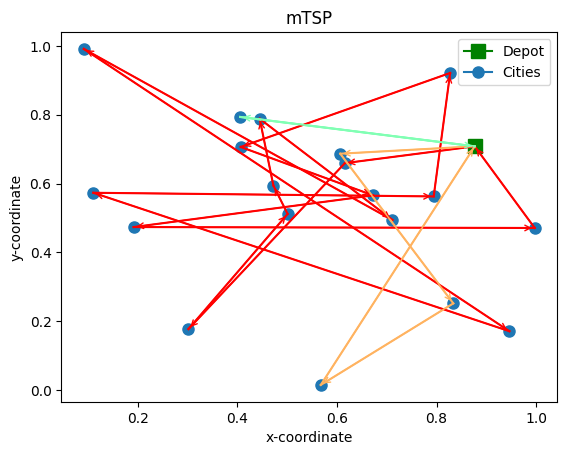

In [12]:
td = td.detach().cpu()
# if batch_size greater than 0 , we need to select the first batch element
if td.batch_size != torch.Size([]):
    td = td[0]

num_agents = td["num_agents"]
locs = td["locs"]
actions = td["action"]

depot_loc = td["locs"][0]
cmap = discrete_cmap(num_agents , 'rainbow')

fig, ax = plt.subplots()

# Add depot action = 0 to before first action and after last action
actions = torch.cat([torch.zeros(1, dtype=torch.int64), actions, torch.zeros(1, dtype=torch.int64)])

# Make list of colors from matplotlib
for i, loc in enumerate(locs):
    if i == 0:
        # depot
        marker = "s"
        color = "g"
        label = "Depot"
        markersize = 10
    else:
        # normal location
        marker = "o"
        color = "tab:blue"
        label = "Cities"
        markersize = 8
    if i > 1: label = ""

    ax.plot(
        loc[0],
        loc[1],
        color=color,
        marker=marker,
        markersize=markersize,
        label=label,
    )

# Plot the actions in order
agent_idx = 0
for i in range(len(actions)):
    if actions[i] == 0:
        agent_idx += 1
    color = cmap(num_agents - agent_idx)

    from_node = actions[i]
    to_node = (
        actions[i + 1] if i < len(actions) - 1 else actions[0]
    )  # last goes back to depot
    from_loc = td["locs"][from_node]
    to_loc = td["locs"][to_node]
    ax.plot([from_loc[0], to_loc[0]], [from_loc[1], to_loc[1]], color=color)
    ax.annotate(
        "",
        xy=(to_loc[0], to_loc[1]),
        xytext=(from_loc[0], from_loc[1]),
        arrowprops=dict(arrowstyle="->", color=color),
        annotation_clip=False,
    )

# Legend
handles, labels = ax.get_legend_handles_labels()

# plot legend
ax.legend(handles, labels)
ax.set_title("mTSP")
ax.set_xlabel("x-coordinate")
ax.set_ylabel("y-coordinate")
plt.show()